# Summary:

#### In this notebook, the trial runs from the preceding notebook ('01_So_What.ipynb') are systematically extended to try to find an optimal configuration for the two models. The model parameters to be fine tuned are: number of epochs, number of layers and the number of units.

\n
\n
\n




# ???update







#### The best performing model configuration will be used in the notebook '03_Blue_in_Green.ipynb' to analyze the impact of adding noise to the clean dataset.


# Table of contents
* [1. Load modules](#Part1_link)
* [2. Setup data](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1  Clean data](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2  Add noise](#Part2.2_link)
* [3. Setup models and evaluate for various hyper-parameter choices](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Compile and fit LSTM and RNN model](#Part3.1_link)
* [4. Visualize results](#Part4_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import sys
sys.path.append("../src/")
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
import seaborn as sns

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import copy


<a id='Part2_link'></a>
# 2. Download data

<a id='Part2.1_link'></a>
### 2.1 Load historical stock data and store locally

In [2]:
# # get historical daily stock data from yahoo finance and store locally
# start_dt = '2015-01-01'
# end_dt = '2020-01-01'

# data_EWZ = yf.download('EWZ', start_dt, end_dt)
# data_BRZU = yf.download('BRZU', start_dt, end_dt)

# # Import the plotting library
# import matplotlib.pyplot as plt
# %matplotlib inline

# # Plot the close price of the AAPL
# data_EWZ['Adj Close'].plot()
# plt.show()

# data_EWZ.to_csv("../data/05_EWZ_data.csv")
# data_BRZU.to_csv("../data/05_BRZU_data.csv")

<a id='Part2.2_link'></a>
### 2.2 Load locally stored data

In [3]:
# load locally stored ETF data
df_EWZ = pd.read_csv("../data/05_EWZ_data.csv", index_col='Date')
df_BRZU = pd.read_csv("../data/05_BRZU_data.csv", index_col='Date')

df_EWZ.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,35.980000,36.000000,35.040001,35.360001,30.774229,17765400
2015-01-05,34.220001,34.410000,34.049999,34.150002,29.721155,22200400
2015-01-06,34.619999,34.990002,34.209999,34.759998,30.252037,21194000
2015-01-07,35.750000,36.099998,35.520000,35.700001,31.070141,16427500
2015-01-08,35.939999,36.570000,35.799999,36.270000,31.566212,14081000


In [4]:
df_BRZU.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2954.0,2954.0,2712.5,2793.0,2691.072998,800
2015-01-05,2513.0,2562.0,2485.0,2502.5,2411.174561,1000
2015-01-06,2597.0,2670.5,2520.0,2639.0,2542.693115,300
2015-01-07,2870.0,2933.0,2814.0,2838.5,2734.912354,400
2015-01-08,2901.5,3055.5,2870.0,2992.5,2883.292725,700


<a id='Part3_link'></a>
# 3. Exploratory data analysis

feature engineering:
To get an indicator for the intra-day volatility, the maximum drawdown as the difference of High (price) and Low (price) is taken and divided by the Open (price). This new feature is called 'Drawdown'

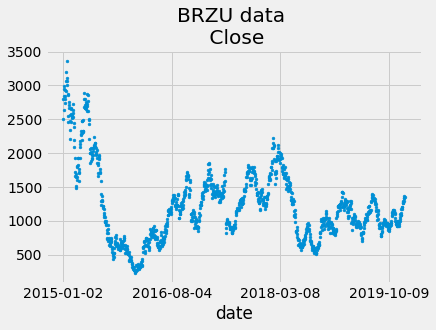

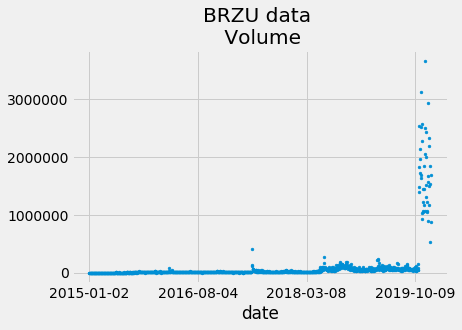

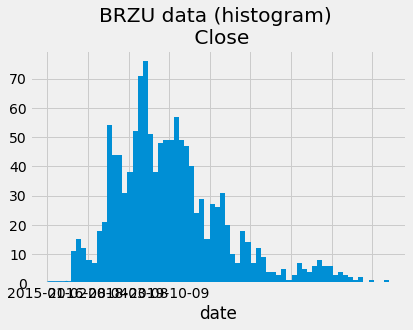

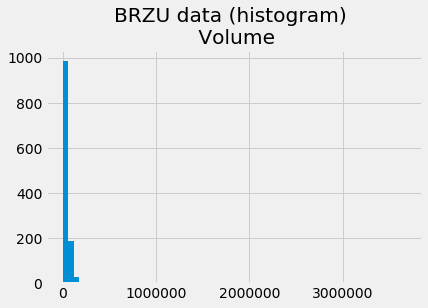

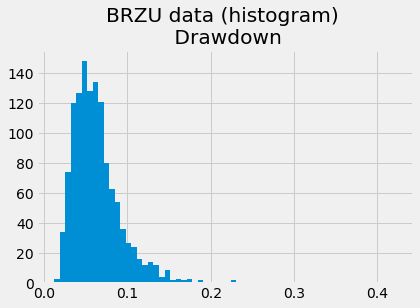

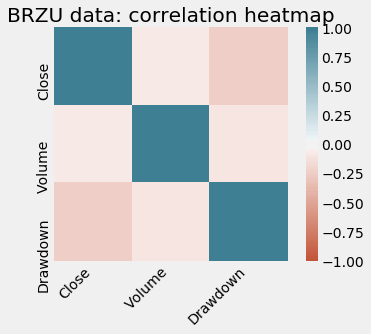

In [5]:
# run below cells for either EWZ or BRZU dataframe

# df, df_name = df_EWZ, 'EWZ'
df, df_name = df_BRZU, 'BRZU'

df_tmp = pd.DataFrame((df['High'] - df['Low'])/df['Open'], columns=['Drawdown'])
df = df.join(df_tmp)

# drop columns that are no longer of interest
drop_cols = ['Open', 'High', 'Low', 'Adj Close']
df = df.drop(drop_cols, axis=1)

# plot results
size = 8
tick_spacing = 400
width = 1

# scatter plots
for col in df.columns:
    fig, ax = plt.subplots(1,1)
    
    x = [x for x in df.index]
    y = [x for x in list(df[col])]
    
    ax.scatter(x, y, s=size)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    ax.set_xlabel('date')
    ax.set_title('{} data \n {}'.format(df_name, col))
    
# histograms
bins = int(len(df)/20)

for col in df.columns:
    df[col].hist(bins=bins)
    plt.title('{} data (histogram) \n {}'.format(df_name, col))
    plt.show()
    plt.close()
    
# correlation
corr = df.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0
                 , cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_title('{} data: correlation heatmap'.format(df_name))

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');


Text(0.5, 1.0, 'BRZU data: Close Prices \n monthly trend decomposition')

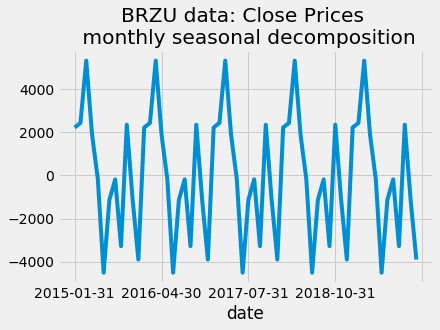

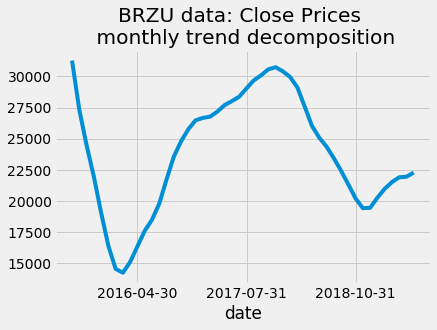

In [6]:
# seasonal decomposition plots

df_tmp = copy.deepcopy(df)

df_tmp.index = pd.to_datetime(df_tmp.index)  # make index a pandas timestamp

# resample data to monthly sums
resampling_period = 'M'
df_tmp = df_tmp.resample(resampling_period).sum()


# get seasonal decomposition plots on Close price
a = seasonal_decompose(df_tmp['Close'], model='add')

# plot data
size = 8
tick_spacing = 15
width = 1

# plot seasonal data
fig, ax = plt.subplots(1, 1)

x = [str(x)[:10] for x in a.seasonal.index]
y = [x for x in list(a.seasonal.values)]

ax.plot(x, y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_xlabel('date')
ax.set_title('{} data: Close Prices \n {}'.format(df_name, 'monthly seasonal decomposition'))

# plot trend data
fig, ax = plt.subplots(1, 1)
x = [str(x)[:10] for x in a.trend.index]
y = [x for x in list(a.trend.values)]

ax.plot(x, y)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

ax.set_xlabel('date')
ax.set_title('{} data: Close Prices \n {}'.format(df_name, 'monthly trend decomposition'))


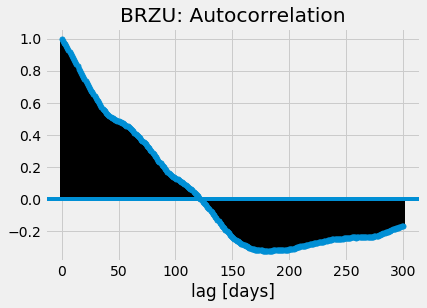

In [7]:
# plot autocorrelation on close prices
sm.graphics.tsa.plot_acf(df.Close.values.squeeze(), lags=300, alpha=1)
plt.title('{}: Autocorrelation'.format(df_name))
plt.xlabel('lag [days]')
plt.show()

<a id='Part3_link'></a>
# 3. Compile and fit models

<a id='Part3.1_link'></a>
### 3.1 Setup framework

In [8]:
# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# load dataframe into object
mdq._selected_features = ['Close']
mdq.df = pd.DataFrame(df.Close)  # dismiss all other data except for prices

# initialize dataset from dataframe 
mdq.initialize_dataset()

# standardize data
mdq.standardize_data()

# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)

# model configuration
units = 128  # number of units in each neural network layer
num_layers = 2  # total number of layers
epochs = 20


<a id='Part3.2_link'></a>
### 3.2 Train and validate model

In [ ]:
# choose a few past history sizes
past_history_size = 10 * future_target_size

# initialize results dictionary
res = {'model_type': [], 'past_history_size': [], 'val_mse': []
       , 'mse': [], 'total_training_time': []}

# model type 
model_types = ['RNN', 'LSTM']

for model_type in model_types:

    # generate train and validation data
    mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size)

    # set number of steps per epoch
    num_samples = mdq._num_samples
    steps_per_epoch = int(num_samples/future_target_size)
    validation_steps = int(steps_per_epoch/2)

    # compile model
    mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

    # fit model
    mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
                  ,validation_steps=validation_steps, model_type=model_type)

    # get errors
    history = mdq._histories[model_type]
    val_mse = history.history['val_mse'][-1]
    mse = history.history['mse'][-1]

    # get total training time
    total_training_time = sum(mdq._time_callbacks[model_type].times)

    # append results to results dictionary
    res['model_type'].append(model_type)
    res['past_history_size'].append(past_history_size)
    res['val_mse'].append(val_mse)
    res['mse'].append(mse)
    res['total_training_time'].append(total_training_time)

training set shape: x:(810, 70, 1), y:(810, 7, 1)
validation set shape: x:(301, 70, 1), y:(301, 7, 1)
Epoch 1/20
115/115 [==============================] - 2s 17ms/step - loss: 0.1185 - mse: 0.1185 - val_loss: 0.0337 - val_mse: 0.0337
Epoch 2/20
115/115 [==============================] - 2s 16ms/step - loss: 0.0773 - mse: 0.0773 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 3/20
115/115 [==============================] - 2s 17ms/step - loss: 0.0744 - mse: 0.0744 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 4/20
115/115 [==============================] - 2s 16ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 5/20
115/115 [==============================] - 2s 16ms/step - loss: 0.0699 - mse: 0.0699 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 6/20
115/115 [==============================] - 2s 17ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0312 - val_mse: 0.0312
Epoch 7/20
115/115 [==============================] - 2s 17ms/step - loss: 0.0675 - mse: 0.0675 - va

<a id='Part4_link'></a>
# 4. Visualize and save results

In [ ]:
# transform dictionary to dataframe
df_res = pd.DataFrame(res)

# store dataframe as csv locally
df_res.to_csv('../data/05_results_{}.csv'.format(df_name))

In [ ]:
# plot validation errors
num = 2

for model_type in model_types:
    mdq.plot_history(model_type=model_type)
    
    for x, y in mdq._val_data.take(3):
        mdq.multi_step_plot(x[num], y[num], mdq._models[model_type].predict(x)[:1], xlabel=None
                            , title=model_type + ' on {} data'.format(df_name))